# TP Estadística e Inferencia II - Parte 1

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import matplotlib . pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
import preliz as pz

In [4]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Parte 1: Análisis exploratorio de datos (EDA)

1. **Carga y descripción del dataset**  
+ Cargar el dataset Iris.  
+ Identificar las variables (numéricas y categóricas).  
+ Describir brevemente cada variable (nombre, tipo y rango).

In [2]:
iris = load_iris(as_frame=True).frame
iris['species'] = iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
iris.drop(columns=['target'], inplace=True)

In [3]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Las variables númericas son las relacionadas con las mediciones de las flores:
+ ``sepal length (cm)``
+ ``sepal width (cm)``
+ ``petal length (cm)``
+ ``petal width (cm)``

Mientras que la única variable categorica son ``target`` y ``species`` (son la misma columna mapeada).

2. **Estadísticas descriptivas:**  
+ Calcular media, mediana, desviación estándar y rangos para cada variable numérica.
+ Realizar la tabla de frecuencia de las especies.

In [5]:
iris.describe(exclude=[int, object])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
iris.species.value_counts().to_frame()

,count
species,
setosa,50
versicolor,50
virginica,50


3. **Visualización univariada**
+ Graficar histogramas o densidades de cada variable numérica diferenciando por especie.

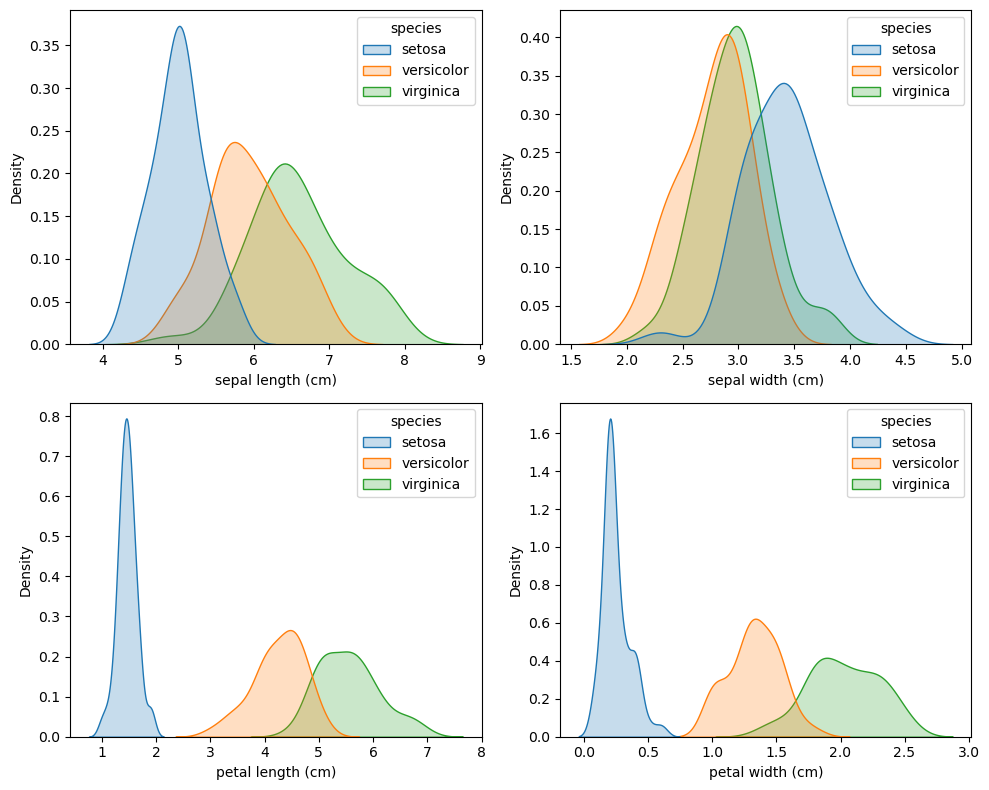

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.kdeplot(data=iris, x='sepal length (cm)', hue='species', ax=axes[0, 0], fill=True)
sns.kdeplot(data=iris, x='sepal width (cm)', hue='species', ax=axes[0, 1], fill=True)
sns.kdeplot(data=iris, x='petal length (cm)', hue='species', ax=axes[1, 0], fill=True)
sns.kdeplot(data=iris, x='petal width (cm)', hue='species', ax=axes[1, 1], fill=True)
plt.tight_layout();

+ ``sepal length``: Virginica tiene generalmente valores más altos que Versicolor que a su vez suele superar a Setosa.  
+ ``sepal width``: Virginica y Versicolor poseen valores similares y Setosa suele tener un sépalo más ancho.
+ ``petal length``: Setosa suele tener el pétalo más corto y con menor varianza. Versicolor y Virginica tienen varianzas similares, con los pétalos de Virginica siedo generalmente más largos.
+ ``petal width``: Las distribuciones son muy similares a la anterior.

4. **Visualización bivariada**
+ Graficar _scatter plots_ (o _pair plots_) entre pares de variables numéricas.
+ Colorear por especie para ver la separación entre clases

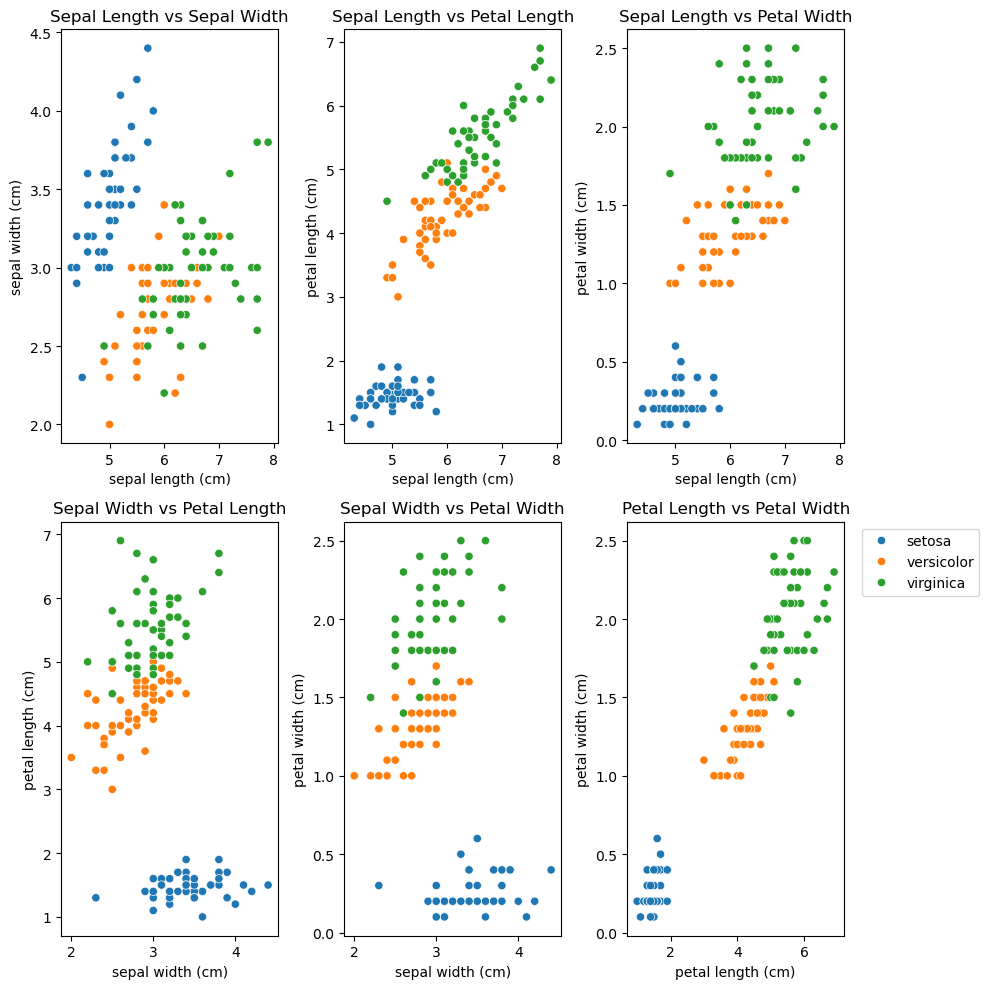

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
sns.scatterplot(data=iris, x='sepal length (cm)', y='sepal width (cm)', hue='species', ax=axes[0, 0], legend=False)
sns.scatterplot(data=iris, x='sepal length (cm)', y='petal length (cm)', hue='species', ax=axes[0, 1], legend=False)
sns.scatterplot(data=iris, x='sepal length (cm)', y='petal width (cm)', hue='species', ax=axes[0, 2], legend=False)
sns.scatterplot(data=iris, x='sepal width (cm)', y='petal length (cm)', hue='species', ax=axes[1, 0], legend=False)
sns.scatterplot(data=iris, x='sepal width (cm)', y='petal width (cm)', hue='species', ax=axes[1, 1], legend=False)
sns.scatterplot(data=iris, x='petal length (cm)', y='petal width (cm)', hue='species', ax=axes[1, 2])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].set_title('Sepal Length vs Sepal Width')
axes[0, 1].set_title('Sepal Length vs Petal Length')
axes[0, 2].set_title('Sepal Length vs Petal Width')
axes[1, 0].set_title('Sepal Width vs Petal Length')
axes[1, 1].set_title('Sepal Width vs Petal Width')
axes[1, 2].set_title('Petal Length vs Petal Width')
plt.tight_layout();

5. **Análisis preliminar**
+ Identificar si hay variables más discriminantes entre especies.
+ Comentar relaciones visibles entre variables y especies

En el gráfico anterior se aprecia que, en general, las variables presentan correlaciones positivas: a medida que aumenta el tamaño de una parte de la flor, tiende a aumentar el de las otras. Sin embargo, esta relación es más clara en las especies Versicolor y Virginica, mientras que en Setosa las medidas del sépalo y del pétalo parecen menos asociadas.

Como fue visto en la visualización univariada (3), los atributos más discriminantes pueden ser las medidas sobre el pétalo ya que sus distribuciones casi no se superponen.

## Parte 2: Modelos Bayesianos
### A) Modelo bayesiano no jerárquico

6. **Elegir una variable numérica** (por ejemplo, Sepal.Length).

In [8]:
sepal_length_data = iris['sepal length (cm)'].values

7. **Asumir que los valores de esa variable**, para cada especie, provienen de una distribución Normal con media y desviación específicas para cada especie:

$$ y_{ij} \sim \mathcal{N}(\mu_j, \sigma_j^2) $$


Asumimos que, para cada especie setosa ,versicolor,virginica,
la variable **Sepal.Length** sigue:

$$
y_{ij} \sim N(\mu_j, \sigma_j^2), \quad i = 1, \dots, n_j
$$

donde

- $\mu_j$: media de **Sepal.Length** para la especie $j$
- $\sigma_j$: desvío estándar dentro de la especie $j$



8. **Especificar priors independientes** para $\mu_j$ y $\sigma_j$

En este modelo asumimos que, para cada especie, las longitudes de sépalo siguen una distribución normal con una media y una desviación estándar propias.  
Es decir, cada observación dentro de la especie *j* se modela como:

$$
y_{ij} \sim \mathcal{N}(\mu_j, \sigma_j^2)
$$

Para los parámetros usamos **priors independientes** en cada especie:

- **Medias** ($\mu_j$): se modelan con una distribución Normal centrada en 5.5 y con una desviación estándar de 2.  
  Esto refleja un conocimiento previo razonable sobre el rango de longitudes de sépalo y, al mismo tiempo, deja suficiente flexibilidad para que los datos ajusten los valores finales.

- **Desviaciones estándar** ($\sigma_j$): se modelan con un prior $\text{HalfNormal}(1)$, que asegura valores positivos y además es más realista respecto a la variabilidad que muestran los datos del iris (en general entre 0.3 y 0.5 cm).

En conjunto, estos priors son **débiles pero informativos**, lo que significa que guían el modelo hacia valores plausibles sin imponer restricciones fuertes.


9. **Implementar el modelo con PyMC** y extraer muestras posteriores de $\mu_j$ y $\sigma_j$

In [9]:
categories = np.array(["setosa", "versicolor", "virginica"])

idx = pd.Categorical(iris["species"], categories=categories).codes

coords = {"species": categories, "species_flat": categories[idx]}

In [11]:
with pm.Model(coords=coords) as non_hier_model:
    μ = pm.Normal("μ", mu=5.5, sigma=2, dims="species")
    σ = pm.HalfNormal("σ", sigma=1, dims="species")

    y = pm.Normal("y_obs", mu=μ[idx], sigma=σ[idx], observed=sepal_length_data, dims="species_flat")

    idata_no_j = pm.sample(chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


10. **Graficar distribuciones posteriores de las medias por especie** y comparar con los
valores observados.

Visualizamos las distribuciones posteriores de las medias ($\mu_j$) para cada especie y las compararemos con las medias observadas en los datos originales. Esto nos dará una idea de la inferencia que el modelo ha hecho sobre los valores centrales de la longitud del sépalo para cada grupo.

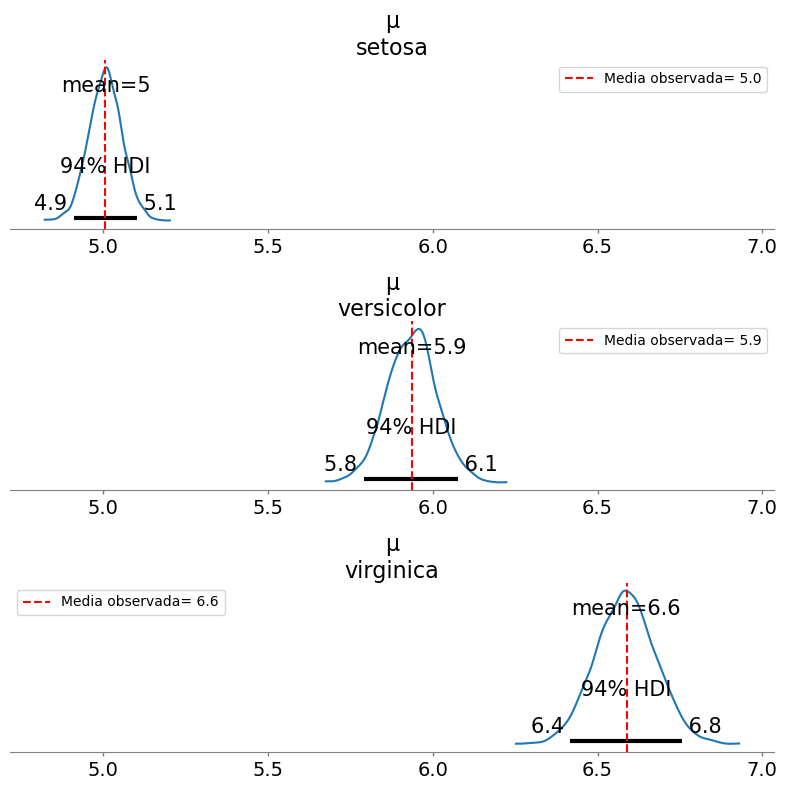

In [12]:
observed_means = iris.groupby("species")["sepal length (cm)"].mean()

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

for i, species in enumerate(categories):
    ax = axes[i]
    az.plot_posterior(idata_no_j, var_names=["μ"], coords={"species": [species]}, ax=ax)
    ax.axvline(observed_means[species], color='red', linestyle='--', label='Media observada= {:.1f}'.format(observed_means[species]))
    ax.legend()

plt.tight_layout();

#### Interpretación de los gráficos

**Setosa**:
La distribución posterior está centrada en torno a **5.0 cm**, con un intervalo creíble del 94% entre **4.9 y 5.1 cm**. La media observada (línea roja) coincide con la media posterior, lo que indica que el modelo captura muy bien los datos.

**Versicolor**:
La media posterior es de aproximadamente **5.9 cm**, con un intervalo de credibilidad entre **5.8 y 6.1 cm**. La línea roja de la media observada se ubica en el centro de la distribución, lo cual muestra consistencia entre datos y modelo. La dispersión es un poco mayor que en *setosa*, reflejando **más variabilidad** en esta especie.

**Virginica**:
La media posterior está cerca de **6.6 cm**, con un intervalo entre **6.4 y 6.8 cm**. De nuevo, la media observada coincide bien con la estimación posterior. Aunque el intervalo es más amplio que en *setosa*, sigue siendo relativamente preciso, mostrando que el **sépalos de virginica son consistentemente más largos**.

**Comparación entre especies**:
Los tres intervalos de credibilidad no se superponen, lo que brinda **evidencia sólida de que las medias de longitud de sépalo difieren entre las tres especies**. Además, las coincidencias entre las medias observadas y las distribuciones posteriores confirman que el modelo bayesiano ajustado describe adecuadamente los datos.

### B) Modelo bayesiano jerárquico

11. Para la misma variable, suponer que las medias de las especies provienen de una distribución común:

$$ \mu_j \sim \mathcal{N}(\mu_{\text{global}}, \tau^2) $$

Esto implica que las medias de cada especie ($\mu_j$) no son completamente independientes, sino que están relacionadas a través de una media global ($\mu_{\text{global}}$) y una varianza ($\tau^2$) que describe la variabilidad entre las medias de las especies.

12. **Especificar priors para $\mu_{\text{global}}$, $\tau$ y $\sigma_j$.**

En este modelo asumimos que las medias de cada especie provienen de una distribución común centrada en una media global.  
Los priors que usamos son los siguientes:

- **Media global ($\mu_{\text{global}}$):**  
  $\mu_{\text{global}} \sim \mathcal{N}(5.5, 2)$  
  Se centra en 5.5 cm, un valor razonable para la longitud de sépalo en el iris, con suficiente dispersión para cubrir valores típicos sin ser restrictivo.

- **Variabilidad entre especies ($\tau$):**  
  $\tau \sim \text{HalfNormal}(1)$  
  Controla cuánto pueden diferir las medias de cada especie respecto a la media global.

- **Desviaciones estándar dentro de cada especie ($\sigma_j$):**  
  $\sigma_j \sim \text{HalfNormal}(1)$  
  Garantiza valores positivos y describe la variabilidad de las observaciones dentro de cada especie.

---

13.**Implementar el modelo jerárquico en PyMC**

A continuación, implementaremos el modelo jerárquico en PyMC. Definiremos los priors para $\mu_{\text{global}}$, $\tau$ y $\sigma_j$, y luego especificaremos la verosimilitud para los datos observados.

In [13]:
with pm.Model(coords=coords) as hier_model:
    # Hiperpriors
    μ_global = pm.Normal("μ_global", mu=5.5, sigma=2)
    τ = pm.HalfNormal("τ", sigma=1)

    # Priors
    μ = pm.Normal("μ", mu=μ_global, sigma=τ, dims="species")
    σ = pm.HalfNormal("σ", sigma=1, dims="species")

    y = pm.Normal("y_obs", mu=μ[idx], sigma=σ[idx], observed=sepal_length_data, dims="species_flat")

    # Muestreo posterior
    idata_jer = pm.sample(chains=4, target_accept=0.9, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_global, τ, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


In [15]:
az.summary(idata_jer, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_global,5.82,0.55,4.76,6.90,0.01,0.01,3763.79,2585.63,1.0
μ[setosa],5.01,0.05,4.91,5.11,0.00,0.00,5834.12,2985.86,1.0
μ[versicolor],5.93,0.07,5.79,6.07,0.00,0.00,6181.45,2771.53,1.0
μ[virginica],6.58,0.09,6.41,6.76,0.00,0.00,7268.65,3111.41,1.0
τ,0.95,0.40,0.36,1.67,0.01,0.01,4225.29,3026.55,1.0
σ[setosa],0.36,0.04,0.29,0.43,0.00,0.00,7172.18,2677.04,1.0
σ[versicolor],0.53,0.05,0.42,0.63,0.00,0.00,6870.98,3118.57,1.0
σ[virginica],0.65,0.07,0.53,0.78,0.00,0.00,5726.60,3251.36,1.0


El modelo muestra que la **media global** es de aproximadamente **5.82**, lo que representa el promedio común entre todas las especies.  
El valor de **$\tau$** (alrededor de **0.94**) indica que existe una diferencia moderada entre las medias de las especies.  

Las medias estimadas para cada especie son cercanas a:  
- **Setosa**: $\mu \approx 5.01$  
- **Versicolor**: $\mu \approx 5.94$  
- **Virginica**: $\mu \approx 6.58$  

Se observa que todas están alineadas con la media global, lo que refleja el efecto de *shrinkage* típico de los modelos jerárquicos.  

Además, las **desviaciones estándar** dentro de cada especie son bajas:  
- Setosa: $\sigma \approx 0.36$  
- Versicolor: $\sigma \approx 0.53$  
- Virginica: $\sigma \approx 0.65$  

Esto significa que los valores de sépalo dentro de cada especie no varían demasiado.  

Finalmente, los valores de **$\hat{R} = 1.0$** en todos los parámetros confirman que el muestreo fue estable y que las cadenas convergieron adecuadamente.


14. **Graficar las distribuciones posteriores** de las medias jerárquicas y compararlas con
el modelo no jerárquico.

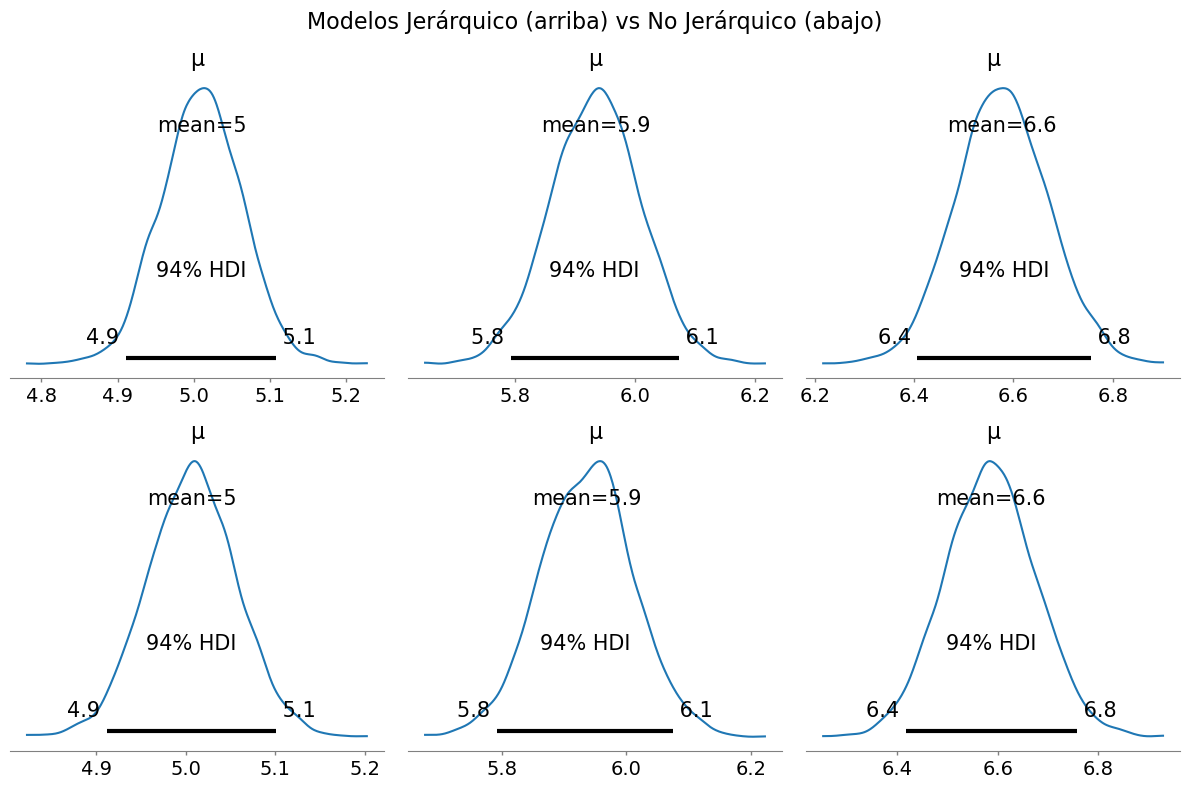

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

az.plot_posterior(idata_jer, var_names=['μ'], coords={"species": 'setosa'}, ax=axes[0, 0])
az.plot_posterior(idata_jer, var_names=['μ'], coords={"species": 'versicolor'}, ax=axes[0, 1])
az.plot_posterior(idata_jer, var_names=['μ'], coords={"species": 'virginica'}, ax=axes[0, 2])

az.plot_posterior(idata_no_j, var_names=['μ'], coords={"species": 'setosa'}, ax=axes[1, 0])
az.plot_posterior(idata_no_j, var_names=['μ'], coords={"species": 'versicolor'}, ax=axes[1, 1])
az.plot_posterior(idata_no_j, var_names=['μ'], coords={"species": 'virginica'}, ax=axes[1, 2])

plt.suptitle('Modelos Jerárquico (arriba) vs No Jerárquico (abajo)', fontsize=16)
plt.tight_layout();

En los tres casos (*setosa, versicolor y virginica*), las distribuciones posteriores de las medias son prácticamente iguales en el modelo jerárquico y en el no jerárquico.

- **Setosa:** la media posterior es de ~5.0 cm, con un intervalo creíble estrecho (4.9–5.1 cm). No se aprecian diferencias relevantes entre ambos modelos.  

- **Versicolor:** la media posterior es de ~5.9 cm, con intervalo 5.8–6.1 cm. El jerárquico y el no jerárquico coinciden casi exactamente.  

- **Virginica:** la media posterior es de ~6.6 cm, con intervalo 6.4–6.8 cm. Nuevamente, ambos modelos ofrecen estimaciones prácticamente idénticas.  

15. **Observar si ocurre shrinkage** (medias acercándose al promedio global).

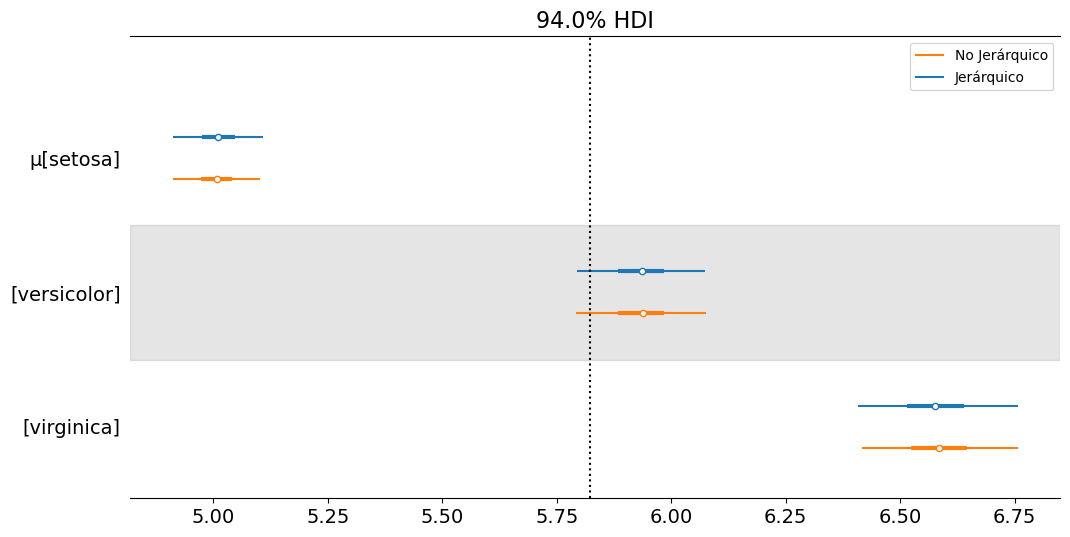

In [25]:
ax = az.plot_forest([idata_jer, idata_no_j], model_names=["Jerárquico", "No Jerárquico"],
               var_names=['μ'], combined=True, figsize=(12, 6))

y_lims = ax[0].get_ylim()

ax[0].vlines(idata_jer.posterior["μ_global"].mean(), *y_lims, colors='black', linestyles=':');

En este caso no se observa un shrinkage evidente. Las medias posteriores de *setosa* (5.0 cm), *versicolor* (5.9 cm) y *virginica* (6.6 cm) son prácticamente iguales en el modelo jerárquico y en el no jerárquico, y coinciden muy bien con las medias observadas. Esto se debe a que cada especie cuenta con una cantidad grande de datos (50 observaciones) y las medias están claramente separadas entre sí. Al haber tanta evidencia, el modelo jerárquico no necesita “tirar” las medias hacia la media global. En cambio, en situaciones con menos datos por grupo o con medias más cercanas, sí se esperaría ver el efecto de contracción característico de los modelos jerárquicos.


## Parte 3: Comparación y conclusiones
OBSERVACIÓN: Pueden realizar una comparación de modelos utilizando las siguientes métricas de ajuste, o de forma manual con alguna otra herramienta que consideren.


16. Calcular métricas de ajuste (WAIC o LOO) para comparar el modelo no jerárquico
vs jerárquico.

Primero computamos las log-likelihoods que son necesarias para calcular las métricas principales de ajuste

In [26]:
with non_hier_model:
    pm.compute_log_likelihood(idata_no_j, extend_inferencedata=True)

Output()

In [27]:
with hier_model:
    pm.compute_log_likelihood(idata_jer, extend_inferencedata=True)

Output()

Comparamos los modelos con LOO ya que es más robusto que WAIC.

In [32]:
df_comp = az.compare({"Jerárquico": idata_jer, "No Jerárquico": idata_no_j})
df_comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
No Jerárquico,0,-109.274169,5.242453,0.000000,1.0,8.498931,0.000000,False,log
Jerárquico,1,-109.541200,5.481903,0.267031,0.0,8.503027,0.130463,False,log


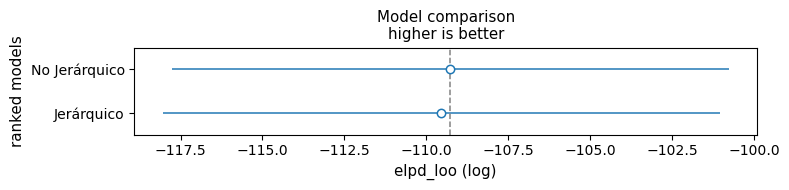

In [43]:
az.plot_compare(df_comp, figsize=(8, 2), plot_kwargs={'color_ic': 'C0'})
plt.tight_layout();

17.**Discutir cuál modelo se ajusta mejor a los datos y por qué.**

Según la comparación basada en el ELPD, ambos modelos presentan valores prácticamente idénticos. El modelo no jerárquico obtiene un ELPD ligeramente mayor ($-109.27$ vs $-109.54$), pero la diferencia es muy pequeña y se encuentra dentro del error estándar ($\approx 8.5$), por lo que no es estadísticamente relevante. Esto indica que **ambos modelos se ajustan de manera similar a los datos**, sin evidencia clara de que uno prediga mejor que el otro.

Al ser tan parecidos, la manera de desempatar puede ser la simplicidad. El modelo No Jerárquico presenta un ``p_loo`` (número efectivo de parámetros) menor, por lo tanto es el más simple.

18. (Opcional) **Usar ambos modelos para predecir nuevas observaciones** (posterior predictivo) y comparar resultados.

In [44]:
with non_hier_model:
    pm.sample_posterior_predictive(idata_no_j, extend_inferencedata=True)

Sampling: [y_obs]


Output()

In [45]:
with hier_model:
    pm.sample_posterior_predictive(idata_jer, extend_inferencedata=True)

Sampling: [y_obs]


Output()

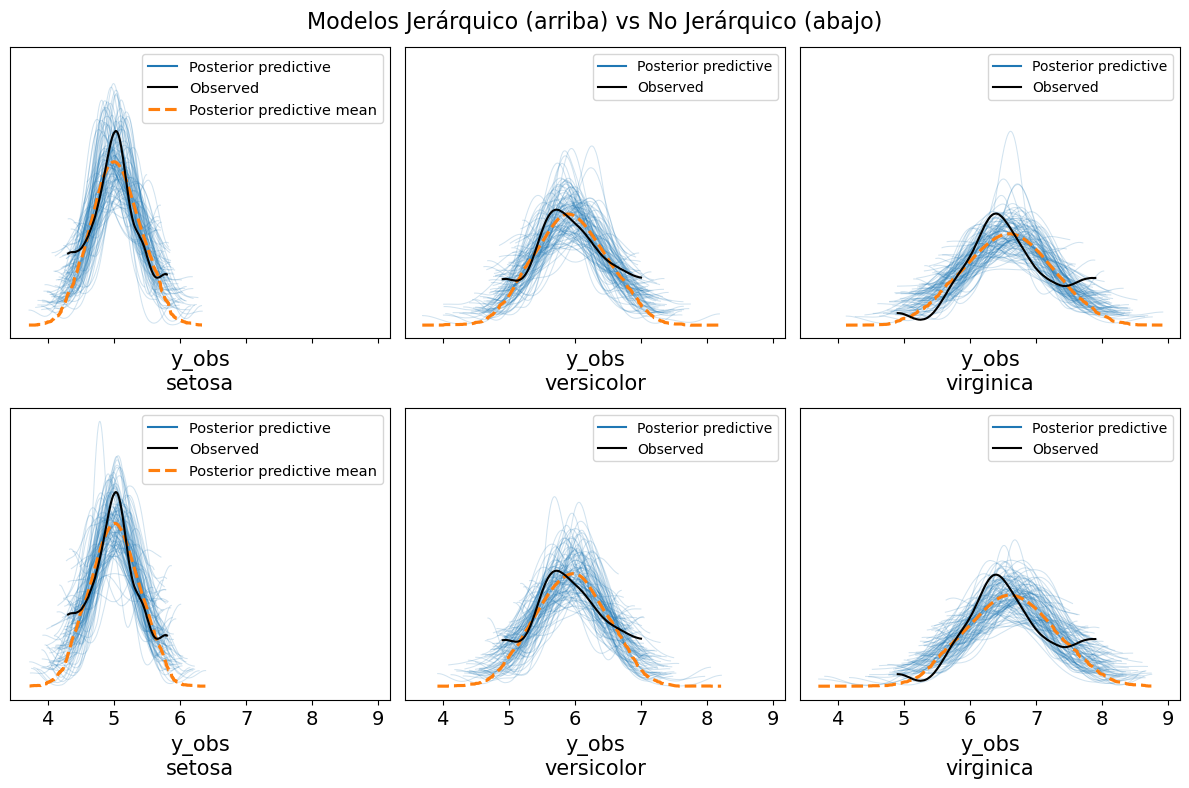

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes_fila1 = axes[0, :]
axes_fila2 = axes[1, :]

az.plot_ppc(
    idata_no_j,
    num_pp_samples=100,
    coords={"species_flat": [categories]},
    flatten=[],
    ax=axes_fila2,
)
az.plot_ppc(
    idata_jer,
    num_pp_samples=100,
    coords={"species_flat": [categories]},
    flatten=[],
    ax=axes_fila1,
)
plt.suptitle('Modelos Jerárquico (arriba) vs No Jerárquico (abajo)', fontsize=16)
plt.tight_layout();

Comparar las distribuciones predictivas _a posteriori_ nos confirma lo que vimos con las estimaciones del ELPD-LOO, que ningún modelo tiene una capacidad predictiva superior a la del otro.

19. **Resumir hallazgos** del análisis exploratorio y del modelado bayesiano. Comentar
ventajas y limitaciones del enfoque jerárquico en este contexto.

En el modelado bayesiano de ``sepal_length``, tanto el modelo Jerárquico como el No Jerárquico mostraron resultados **prácticamente equivalentes**: las distribuciones posteriores de las medias por especie fueron prácticamente indistinguibles, las distribuciones predictivas muy similares y los valores de ELPD-LOO casi idénticos, con una ligera ventaja del modelo no jerárquico. Además, **no se observó un efecto de shrinkage apreciable**, lo que sugiere que las medias por grupo no se benefician del intercambio de información entre especies.

El modelo jerárquico **no aporta una mejora en la capacidad predictiva** y añade complejidad innecesaria, mientras que el modelo no jerárquico resulta más simple (menor ``p_loo``) y suficiente para describir los datos.